In [1]:
import pandas as pd
from decimal import *
from binance.client import Client
from binance import BinanceSocketManager

In [2]:
run credentials.ipynb

In [3]:
client = Client(tradKey, tradSecret)

In [4]:
run functions.ipynb

In [5]:
run db_helper.ipynb

In [6]:
asset='SHIBBUSD'

In [7]:
engine = create_db(asset)

In [8]:
asset_df = pd.read_sql(asset, engine)

<AxesSubplot:>

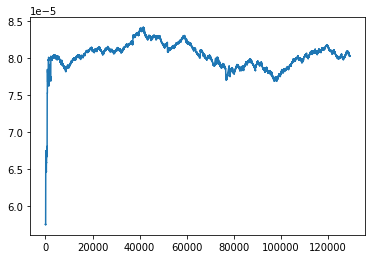

In [9]:
asset_df.Price.plot()

In [10]:
#Trendfollowing
#If the crypto was rising by x % -> Buy
#Exit when profit is > 0.15 % or loss is crossing - 0.15% 

In [11]:
def open_position(symbol, opts):
    while True:
        df = pd.read_sql(symbol, engine)        
        loopback_period = df.iloc[- opts['loopback_in_seconds'] :]
        cumret = get_cumulative_return(loopback_period.Price)
        if cumret[cumret.last_valid_index()] > (opts['buy_pct'] / 100):
            return market_order(symbol=symbol, side='BUY', quantity=opts['qtty'])

In [12]:
def close_position(symbol, order, opts):
    while True:
        df = pd.read_sql(symbol, engine)
        sincebuy = df.loc[df.Time > pd.to_datetime(order['transactTime'], unit='ms')]
        if len(sincebuy) > 1:
            sincebuyret = get_cumulative_return(sincebuy.Price)
            last_entry = sincebuyret[sincebuyret.last_valid_index()]
            if last_entry > (opts['sell_pct'] / 100) or last_entry < -(opts['sell_pct_down'] / 100):
                return market_order(symbol=symbol, side='SELL', quantity=opts['qtty'])

In [13]:
def live_trading_strategy(symbol,opts):
    buy_order = open_position(symbol,opts)
    blst = buy_order['fills'][0]
    blst['type'] ='Buy'
    #blst['tp'] = float(blst['commission']) + float(blst['price'])
    df = pd.DataFrame([blst.values()], columns=blst.keys())
    print(df)

    sell_order = close_position(symbol, buy_order, opts)    
    slst = sell_order['fills'][0]
    slst['type'] ='Sell'
    #slst['tp'] = float(slst['commission']) + float(slst['price'])
    df = pd.DataFrame([slst.values()], columns=slst.keys())
    print(df)

    #profit_n_lost = float(slst['tp']) - float(slst['tp'])
    profit_n_lost_litteral = "lost"
    if(slst['price'] > blst['price']):
        profit_n_lost_litteral = "profit"

    profit_n_lost =  Decimal(slst['price']) - Decimal(blst['price'])
    print('Trading ends up with %s %s' % (profit_n_lost, profit_n_lost_litteral) )
    return {
        "pnl" : profit_n_lost_litteral,
        "earn": profit_n_lost
    }

In [14]:
opts = {
    'loopback_in_seconds': 60, 
    'qtty':300000,
    'buy_pct':0.10, 
    'sell_pct':0.20,
    'sell_pct_down':0.15
}
while True:
    total = 0
    pnl_earn = live_trading_strategy(asset, opts)
    pnl = pnl_earn['pnl']
    earn = pnl_earn['earn']
    if pnl == "lost":
        opts['sell_pct_down'] = opts['sell_pct_down']-0.01
        opts['sell_pct'] = opts['sell_pct']-0.01
    else:
        opts['sell_pct'] = opts['sell_pct']+0.01
        opts['sell_pct_down'] = opts['sell_pct_down']+0.01

    total = total + earn;
    if opts['sell_pct'] < 0.10 or opts['sell_pct_down'] < 0.05:
        print("Total earn after trade %s" % float(earn))
        break

        price        qty  commission commissionAsset   tradeId type
0  0.00008031  300000.00  0.00003825             BNB  31814300  Buy
        price        qty  commission commissionAsset   tradeId  type
0  0.00008021  300000.00  0.00003974             BNB  31814708  Sell
Trading ends up with -1.0E-7 lost
        price        qty  commission commissionAsset   tradeId type
0  0.00008019  300000.00  0.00003825             BNB  31814733  Buy
        price        qty  commission commissionAsset   tradeId  type
0  0.00008007  300000.00  0.00003966             BNB  31814809  Sell
Trading ends up with -1.2E-7 lost
        price        qty  commission commissionAsset   tradeId type
0  0.00007945  300000.00  0.00003825             BNB  31816225  Buy
        price        qty  commission commissionAsset   tradeId  type
0  0.00007971  300000.00  0.00003951             BNB  31817059  Sell
Trading ends up with 2.6E-7 profit
        price        qty  commission commissionAsset   tradeId type
0  0.00

        price        qty  commission commissionAsset   tradeId type
0  0.00007924  300000.00  0.00003825             BNB  31829531  Buy
        price        qty  commission commissionAsset   tradeId  type
0  0.00007912  300000.00  0.00003940             BNB  31829713  Sell
Trading ends up with -1.2E-7 lost
        price        qty  commission commissionAsset   tradeId type
0  0.00007926  300000.00  0.00003825             BNB  31829736  Buy
        price        qty  commission commissionAsset   tradeId  type
0  0.00007908  300000.00  0.00003939             BNB  31829965  Sell
Trading ends up with -1.8E-7 lost
        price        qty  commission commissionAsset   tradeId type
0  0.00007893  255013.00  0.00003251             BNB  31830519  Buy
        price        qty  commission commissionAsset   tradeId  type
0  0.00007879  300000.00  0.00003924             BNB  31830736  Sell
Trading ends up with -1.4E-7 lost
        price        qty  commission commissionAsset   tradeId type
0  0.000